# Introduction

This calculates the exact eigenvectors, eigenvalues and VAMP scores for the Quad Well potential in MSM Builder.  The exact VAMP scores are calculated using a discrete basis set with discretisations of various sizes over the range -1.2 to 1.2 using.  The exact eigenvectors/values are calculated using a very fine grid spacing.   

## Imports and defaults

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy
import pandas as pd

In [2]:
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
def _normalize_eigensystem(u, lv, rv):
    """Normalize the eigenvectors of a reversible Markov state model according
    to our preferred scheme.
    """
    # first normalize the stationary distribution separately
    pi = lv[:, 0]
    lv[:, 0] = lv[:, 0] / np.sum(lv[:, 0])
    
    for i in range(1, lv.shape[1]):
        # the remaining left eigenvectors to satisfy
        # <\phi_i, \phi_i>_{\mu^{-1}} = 1
        lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))

    for i in range(rv.shape[1]):
        # the right eigenvectors to satisfy <\phi_i, \psi_j> = \delta_{ij}
        rv[:, i] = rv[:, i] / np.dot(lv[:, i], rv[:, i])

    return u, lv, rv, pi

In [4]:
def _solve_msm_eigensystem(transmat, k):
    u, lv, rv = scipy.linalg.eig(transmat, left=True, right=True)
    order = np.argsort(-np.real(u))
    u = np.real_if_close(u[order[:k]])
    lv = np.real_if_close(lv[:, order[:k]])
    rv = np.real_if_close(rv[:, order[:k]])
    return _normalize_eigensystem(u, lv, rv)


## The potential

In [5]:
def potential(x):
    return 4 * (x ** 8 + 0.8 * np.exp(-80 * x ** 2) + 0.2 * np.exp(
        -80 * (x - 0.5) ** 2) +
                0.5 * np.exp(-40 * (x + 0.5) ** 2))
# def potential(x):
#     return 1 + np.cos(2 * x)

In [6]:
def stat_dist(x):
    return -np.log(potential(x))

## Transition matrix

### Brownian motion

In [7]:
xmin, xmax = -1.2, 1.2

In [8]:
DIFFUSION_CONST = 1e3
DT = 1e-3
DT_SQRT_2D = DT * np.sqrt(2 * DIFFUSION_CONST)
DOUBLEWELL_GRAD_POTENTIAL = lambda x: -2 * np.sin(2 * x)
QUADWELL_GRAD_POTENTIAL = lambda x: 4 * (
    8 * x ** 7 - 128 * x * np.exp(-80 * x ** 2) - \
    32 * (x - 0.5) * np.exp(-80 * (x - 0.5) ** 2) - 40 * (x + 0.5) * np.exp(
        -40 * (x + 0.5) ** 2))

def _reflect_boundary_conditions(x, min, max):
    if x > max:
        return 2 * max - x
    if x < min:
        return 2 * min - x
    return x

def brownian_transmat(n_grid, lag_time, grad_potential, xmin, xmax, reflect_bc):
    ONE_OVER_SQRT_2PI = 1.0 / (np.sqrt(2 * np.pi))
    normalpdf = lambda x: ONE_OVER_SQRT_2PI * np.exp(-0.5 * (x * x))

    grid = np.linspace(xmin, xmax, n_grid)
    width = grid[1] - grid[0]
    transmat = np.zeros((n_grid, n_grid))
    for i, x_i in enumerate(grid):
        if reflect_bc:
            for offset in range(-(n_grid - 1), n_grid):
                x_j = x_i + (offset * width)
                j = _reflect_boundary_conditions(i + offset, 0, n_grid - 1)

                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)
        else:
            for j, x_j in enumerate(grid):
                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)

        transmat[i, :] = transmat[i, :] / np.sum(transmat[i, :])
    transmat = np.linalg.matrix_power(transmat, lag_time)
    return transmat

### Choose lag time

We want a lag-time for which the timescale separation/eigenvalue separation is large. 

In [9]:
xmin, xmax = -1.2, 1.2
N = 500
T = brownian_transmat(n_grid=N, lag_time=1, grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv, pi =  _solve_msm_eigensystem(T, N)

In [14]:
gaps = []
m = []
taus = np.arange(1, 50, 1)*10
k = 6
for i in taus:
    gaps.append(np.max(u[:k]**i-u[1:k+1]**i))
    m.append(np.argmax(u[:k]**i-u[1:k+1]**i)+1)
#     plt.plot(u[:10]**i, marker='o',  label='tau = {}'.format(i))
gaps = np.array(gaps)
m = np.array(m)

max_gap = np.max(gaps)
tau_at_max = taus[np.argmax(gaps)]
m_at_max = m[np.argmax(gaps)]

In [15]:
gaps

array([0.42526868, 0.54714077, 0.54718174, 0.50231161, 0.44456764,
       0.38681502, 0.34787959, 0.38088541, 0.41066183, 0.43746438,
       0.46152894, 0.48307323, 0.50229821, 0.51938936, 0.53451784,
       0.54784165, 0.55950658, 0.56964716, 0.57838754, 0.58584229,
       0.59211709, 0.59730947, 0.6015094 , 0.60479988, 0.60725745,
       0.60895274, 0.60995087, 0.6103119 , 0.61009122, 0.60933989,
       0.60810498, 0.60642991, 0.60435465, 0.60191609, 0.59914818,
       0.59608222, 0.59274703, 0.58916916, 0.58537306, 0.58138123,
       0.57721438, 0.57289158, 0.56843036, 0.56384684, 0.55915585,
       0.55437101, 0.54950484, 0.54456885, 0.53957358])

In [16]:
m

array([4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

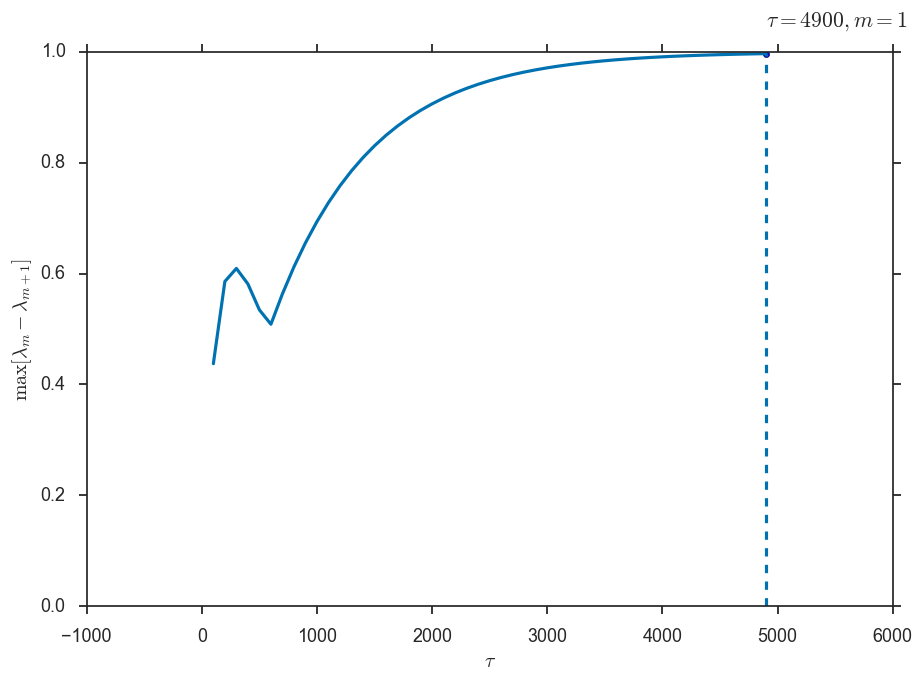

In [12]:
fig, ax = plt.subplots()

cols = sns.color_palette('colorblind', 3)
ax.plot(taus, gaps, label=r'$\Delta \lambda_{max}$', c= cols[0])

# ax2 = ax.twinx()
# ax2.scatter(taus, m, s=10, label=r'$m$', c=cols[1])
ax.scatter(tau_at_max, max_gap)

text = r'$\tau = {0}, m = {1}$'.format(tau_at_max, m_at_max)
t = ax.text(x=tau_at_max, y=max_gap+0.05, s=text)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax.vlines(tau_at_max,0, max_gap, color=cols[0], linestyles='dashed')


lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines, labels, loc=0)
ax.set_ylim((0,1))
ax.set_ylabel(r'$\max[\lambda_{m}-\lambda_{m+1}]$')
ax.set_xlabel(r'$\tau$')

In [22]:
tau_at_max=30

## Potenial/Stationary distribution figure

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/axes/_axes.py:4649: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


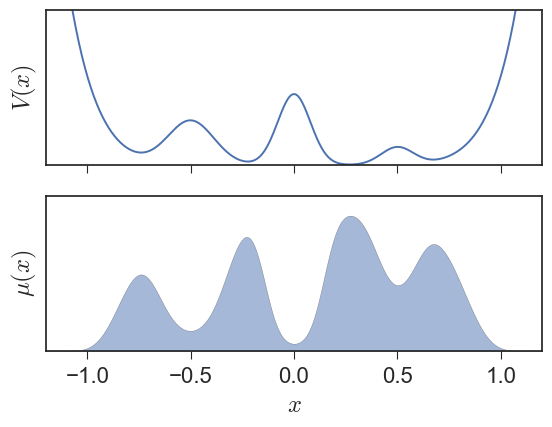

In [23]:
with sns.plotting_context('paper', font_scale=2):
    x = np.linspace(xmin, xmax, N)
    y = potential(x)
    y_stat = pi

    fig, [ax1,ax2] = plt.subplots(2, sharex=True)
    ax1.plot(x,y, label='Potential:\n$V(x) = 4(x^8+0.8 e^{-80 x^2}+0.2 e^{-80 (x-0.5)^2}+0.5 e^{-40 (x+0.5)^2})$')
    ax1.set_xlim((xmin,xmax))
    y1max = 7
    ax1.set_ylim((0,y1max))
    ax1.set_ylabel(r'$V(x)$')

    # y2min = np.floor(np.min(y_stat))
    ax2.fill_between(x, y1=y_stat, y2=0, alpha=0.5, label='Stationary Distribution')
    # ax2.set_ylim(y2min,y2min+y1max)
    ax2.set_xlim((xmin, xmax))

    ax2.set_ylabel(r'$\mu(x)$')
    ax2.set_xlabel(r'$x$')
    for ax in [ax1, ax2]:
        ax.tick_params(
            axis='both',          
            which='both',      
            left='off', 
            right='off',
            top='off',         
            labelleft='off')

    plt.savefig('figures/potential_and_pi.png',bbox_inches='tight',  transparent=True)


In [24]:
T = brownian_transmat(n_grid=N, lag_time=int(tau_at_max), grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv, _ =  _solve_msm_eigensystem(T, N)


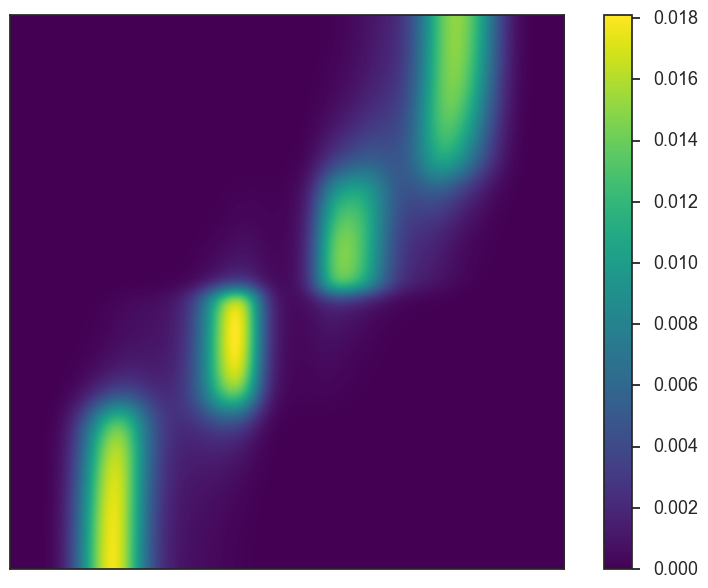

In [25]:

plt.imshow(T, origin='lower', cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('figures/T.png', transparent=True)

## Converge VAMP scores

In [26]:
from numpy.linalg import multi_dot as mdot
from numpy.linalg import svd
from pyemma.util.metrics import vamp_score


In [27]:
n_states = np.logspace(2,3,10).astype(int)
ks = np.arange(2,20).astype(int)
methods = ['vamp1', 'vamp2', 'vampe']
xmin, xmax = -1.2, 1.2
data = {'m': [], 'k': [], 'method': [], 'score': []}

for n_state in n_states:
    T = brownian_transmat(n_grid=n_state, lag_time=int(tau_at_max), grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
    u, lv, rv, _ =  _solve_msm_eigensystem(T, n_state)
    mu = np.real(lv[:,0])
    C_00 = np.diag(mu)
    C_11 = np.diag(mu)
    C_01 = np.dot(C_00, T)
    for k in ks:
        for method in methods:
            score = vamp_score(T, C_00, C_01, C_11, C_00, C_01, C_11, k, score=method)
            data['m'].append(n_state)
            data['k'].append(k)
            data['method'].append(method)
            data['score'].append(score)



KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(data)
df['m'].unique()
df.loc[df['m']==1000, :].to_pickle('vamp_exact_values.pickl')

In [ ]:
g = sns.FacetGrid(col='k', hue='method', col_wrap=5, data=df)
g.map(plt.plot, 'm', 'score').add_legend()
# g.set(xscale='log', xlim=(100,200))


## VAMP vs k: 

In [ ]:
m_exact = 483
g = sns.FacetGrid(hue='method', data=df.loc[df['m']==m_exact, :])
g.map(plt.plot, 'k', 'score').add_legend()



## Implied timescales

In [28]:
T = brownian_transmat(n_grid=n_state, lag_time=int(tau_at_max), grad_potential=QUADWELL_GRAD_POTENTIAL, 
                  xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv, _, = _solve_msm_eigensystem(T, n_state)

In [29]:
u2 = u[1:11]
du2 = u2[:-1]/u2[1:]

In [30]:
its = -tau_at_max/np.log(u2)
dits = its[:-1]/its[1:]

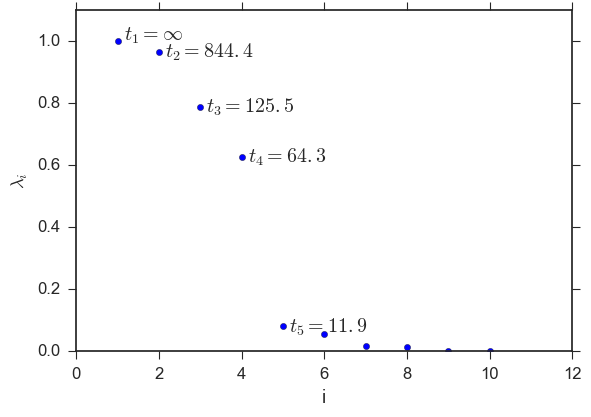

In [31]:
with sns.plotting_context('paper', font_scale=1.5):
    
    its_lab = ['$t_1=\infty$'] + ['$t_{%d}' % (i+2) + '={0:4.1f}$'.format(x) for i, x in enumerate(its)]
    plt.scatter(np.arange(len(u[:10]))+1, u[:10], marker='o')
    offset=[0]+[-0.02]*len(u[1:10])
    for i, x in enumerate(its_lab[:5]): 
        plt.text((i+1.15), u[i]+offset[i], x)
    plt.ylabel('$\lambda_{i}$')
    plt.xlabel('i')
    plt.ylim((0,1.1))
    plt.savefig('figures/eigenspectrum.png', bbox_inches='tight', transparent = True)

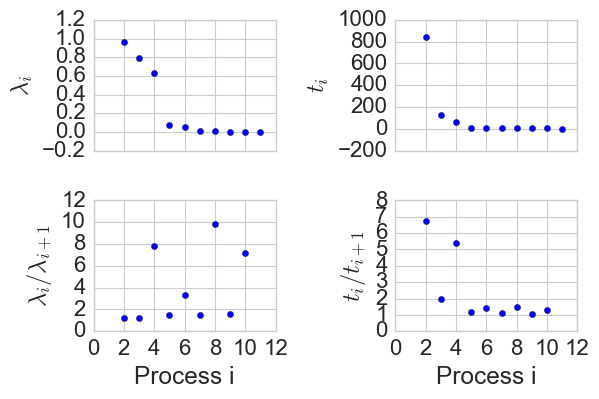

In [33]:
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2,2, sharex=True)
    idx = np.arange(u2.shape[0])+2
    didx = idx[:-1]
    
    ax =  axes[0,0]
    ax.scatter(idx, u2)
    ax.set_ylabel('$\lambda_i$')
    
    ax = axes[0,1]
    ax.scatter(idx, its)
    ax.set_ylabel('$t_i$')

    ax = axes[1,0]
    ax.scatter(didx, du2)
    ax.set_ylabel('$\lambda_i/\lambda_{i+1}$')
    
    ax = axes[1,1]
    ax.scatter(didx, dits)
    ax.set_ylabel('$t_i/t_{i+1}$')
    
    for ax in axes[1,:]:
        ax.set_xlabel('Process i')
        
    plt.tight_layout()
    plt.savefig('figures/gaps.png', transparent=True, bbox_inches='tight')